### RBM 이용하여 얼굴 이모티콘 생성하기

애플, 삼성, 페이스북, 마이크로소프트, LG에서 제공하는 다양한 표정을 나타내는 얼굴 이모티콘 이미지 429장을 RBM을 통해 학습하고 이를 응용하여 직접 얼굴 이모티콘을 생성하는 알고리즘을 만들고자 하였다. 기본적으로 모든 얼굴 이모티콘이 가지고 있는 외형(동그란 얼굴, 눈, 입, 등)을 잘 구현할 수 있는지 시험하고자 하였고, 특정 이모티콘만이 가지고 있는 부수적인 외형(눈물, 하트, 땀, 손, 등)도 생성되는지 확인하고자 하였다.

데이터 출처 : https://www.kaggle.com/danhendrycks/icons50

Sample Images


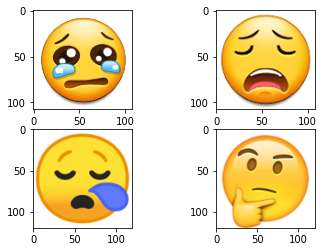

In [193]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from random import randrange

## 원하는 폴더 내의 파일 이름 업로드
path = './../emoticon_face/'
os.chdir(path)
file_names = os.listdir(path)
file_names.remove('.ipynb_checkpoints')

## 이모티콘 샘플 이미지 show 하기
print('Sample Images')
for i in range(4):
    # 샘플 이미지 가져오기
    n = randrange(len(file_names))
    sample_img_title = path + file_names[n]
    sample_img_bgr = cv2.imread(sample_img_title)
    
    # matplotlib와 cv2에서 이미지 색상을 다루는 순서가 각각 RGB, BGR로 다르기 때문에 변환
    sample_img = cv2.cvtColor(sample_img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(sample_img)
plt.show()

RBM을 통해 학습시키기에 앞서 데이터 전처리 과정이 필요하였다. 이미지 파일들의 이름이 규칙적으로 되어 있지 않기 때문에 이미지 관리를 하기 위해서는 파일 이름들을 미리 불러온 후 그 index를 이용하였다. 또한, 이미지들이 120 by 120나 72 by 72의 픽셀을 가지고 있기 때문에 계산 속도 향상과 이미지 크기 통일을 위해 이를 축소할 필요가 있어 72 by 72으로 크기를 줄였다. 색깔을 그대로 유지하기 위해 흑백으로 바꾸지는 않았다. RBM에 넣기 전에 이미지 데이터들을 일직선 형태로(즉, RGB에 대한 것이므로 R줄, G줄, B줄로 총 세줄) 바꾸었다.

In [214]:
### 이미지 로드 & 이미지 사이즈 통일

## 바꾸고자 하는 이미지 size 설정
w, h = 72, 72

## 이미지를 72 by 72 픽셀로 변경해주는 함수
def img_72by72(img):
    img_72 = cv2.resize(img, dsize = (w, h))
    return img_72

## 72 by 72의 이미지 픽셀 데이터를 5184으로 변경해주는 함수
def twoD2oneD(img):
    oneD_img = np.reshape(img, (w*h, 3))
    return oneD_img

In [215]:
## 이미지 파일 로딩
imgs = []
for img_num in range(len(file_names)):
    # 한 이미지 씩 차례 차례 로딩
    img_title = path + file_names[img_num]
    img_original_size = cv2.imread(img_title)
    
    # 픽셀 크기 72 by 72으로 변환
    img_72 = img_72by72(img_original_size)
    
    # value normalization
    img_72_n = img_72 / 255
    
    # 2d 이미지 데이터를 1d로 한줄로 데이터화
    img_data = twoD2oneD(img_72_n)
    
    imgs.append(img_data)

RBM은 scikitlearn을 이용하였다. learning rate가 0.02일 때보다는 0.01일 때 더 학습이 안정적으로 되었다. batch size의 경우엔, 너무 값이 크면 나중에 생성 이모티콘을 출력하였을 때 노이즈가 많이 있어 32로 하였다. 또한, binary hidden unit을 w * h 정도로 하는 것이 가장 학습 기록이 좋았다. Iteration은 5가 넘어간 뒤에는 학습이 잘 되지 않고 이모티콘 생성도 잘 되지 않아 5까지로만 하였다.

In [248]:
## RBM
from sklearn.neural_network import BernoulliRBM

RBM = BernoulliRBM(n_components= w*h, learning_rate = 0.01, batch_size = 32, n_iter = 5, verbose = 1)
nsamples, nx, ny = np.array(imgs).shape
imgs_d2 = np.array(imgs).reshape((nsamples, nx*ny))
RBM.fit(imgs_d2)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -10819.44, time = 18.74s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -8646.60, time = 19.73s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -11207.79, time = 19.76s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -6694.24, time = 19.71s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -4907.58, time = 19.63s


BernoulliRBM(batch_size=32, learning_rate=0.01, n_components=5184, n_iter=5,
             verbose=1)

아래에서는 위의 RBM을 통한 학습 기록을 가지고 이모티콘을 생성하였다. 예시로 총 9개를 만들었다. 기본적으로 모든 이모티콘이 공통적으로 가지고 있는 외형(노랗고 둥근 얼굴)은 갖추었지만 얼굴 중간중간에 붉은 색 노이즈가 생겼다. 이는 특정 이모티콘들이 화난 표정을 지을 때 얼굴이 붉어지는 경우가 있어서 이것이 섞인 것이라 생각한다. 희미하긴 하지만 눈, 입의 존재가 어렴풋이 보이며 9개의 이모티콘 모두가 다른 표정을 짓고 있다. 손이나 하트, 눈물, 땀 등은 아쉽게도 구현되지 못하였다. 전체 사용한 이미지의 갯수가 429장 밖에 되지 않았고, 중간에 차원 동일화를 위하여 이미지의 사이즈를 조절하였던 것이 이와 같은 아쉬운 결과가 나온 이유라고 생각한다.

In [166]:
## 학습한 데이터를 가지고 이모티콘을 만드는 함수
def make_emoticon(sample_num):
    xx = np.random.rand(sample_num, w*h*3)
    for n in range(sample_num):
        xx[n] = RBM.gibbs(xx[n])
    return xx

## 이미지를 120 by 120 픽셀로 변경해주는 함수
def img_120by120(img):
    img_120 = cv2.resize(img, dsize = (120, 120))
    return img_120

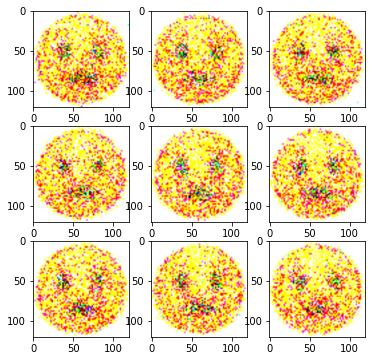

In [249]:
## 이미지 plot
xx = make_emoticon(9)
plt.figure(figsize = (6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    maked_img = xx[i].reshape(w, h, 3) * 255
    
    # 여기에서 만들어진 이미지는 72 by 72의 이미지이므로 다시 120 by 120의 크기로 늘려서 plot
    # 그냥 바로 출력하면 float형의 데이터가 나오므로 이를 uint8으로 바꾸어 출력해야한다.
    maked_img120_bgr = img_120by120(maked_img).astype(np.uint8)
    
    # matplotlib와 cv2에서 이미지 색상을 다루는 순서가 각각 RGB, BGR로 다르기 때문에 변환
    maked_img120 = cv2.cvtColor(maked_img120_bgr, cv2.COLOR_BGR2RGB) 
    
    plt.imshow(maked_img120)
plt.show()